In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import time
from scipy.stats import kurtosis
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the original dataset
original_df = pd.read_csv('Teacher_3026_CDATutterancesWithCodes.csv')
print("Original dataset loaded. Shape:", original_df.shape)

utterances = original_df['utterance'].tolist()

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(utterances)

Original dataset loaded. Shape: (565, 6)


In [3]:
# Apply LDA
n_topics = 20  # You can adjust this
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_lda = lda.fit_transform(X)

print(f"Original data shape: {X.shape}")
print(f"LDA-transformed data shape: {X_lda.shape}")

# Use X_lda for further dimensionality reduction
X = X_lda

Original data shape: (565, 493)
LDA-transformed data shape: (565, 20)


In [4]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# PCA: Use explained variance ratio
pca = PCA()
pca.fit(X_scaled)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
pca_optimal_dims = next(i for i, v in enumerate(cumulative_variance_ratio) if v >= 0.9) + 1

In [6]:
# ICA: Use kurtosis
ica = FastICA(n_components=X_scaled.shape[1], random_state=42)
X_ica = ica.fit_transform(X_scaled)
kurtosis_values = kurtosis(X_ica, axis=0)
ica_optimal_dims = np.sum(np.abs(kurtosis_values) > 1)  # Select components with kurtosis > 1 or < -1

C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


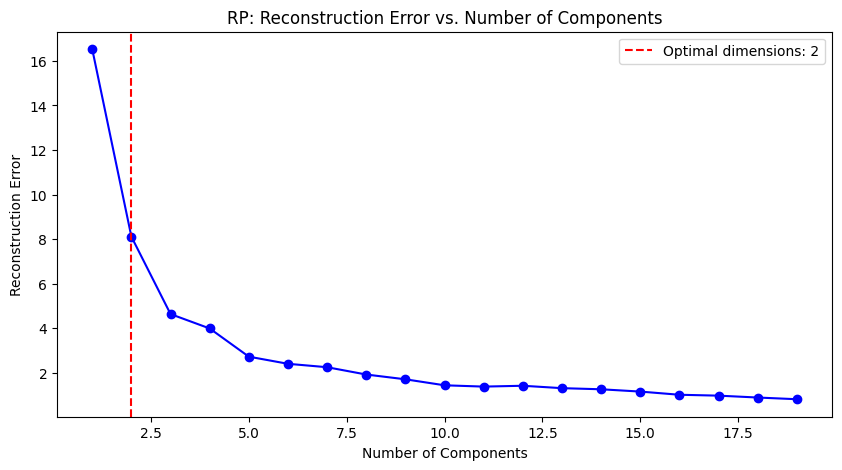

RP optimal dimensions: 2


In [7]:
# RP: Use reconstruction error with elbow method
def rp_reconstruction_error(X, n_components):
    rp = GaussianRandomProjection(n_components=n_components, random_state=42)
    X_rp = rp.fit_transform(X)
    X_reconstructed = np.dot(X_rp, rp.components_)
    return mean_squared_error(X, X_reconstructed)

max_components = min(X_scaled.shape[1], 50)  # Limit to 50 components for efficiency
rp_errors = [rp_reconstruction_error(X_scaled, i) for i in range(1, max_components)]

# Calculate the differences between consecutive errors
error_diffs = np.diff(rp_errors)

# Find the elbow point (where the difference starts to level off)
elbow_point = np.argmin(error_diffs) + 1

rp_optimal_dims = elbow_point + 1  # Add 1 because we started from 1 component

# Plot the reconstruction error
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rp_errors) + 1), rp_errors, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('RP: Reconstruction Error vs. Number of Components')
plt.axvline(x=rp_optimal_dims, color='r', linestyle='--', label=f'Optimal dimensions: {rp_optimal_dims}')
plt.legend()
plt.show()

print(f"RP optimal dimensions: {rp_optimal_dims}")

In [8]:
# UMAP: Use silhouette score
umap_scores = []
for dims in range(2, 11):  # Limit to 10 dimensions for computational efficiency
    umap_reducer = umap.UMAP(n_components=dims, random_state=42)
    X_umap = umap_reducer.fit_transform(X_scaled)
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(X_umap)
    umap_scores.append(silhouette_score(X_umap, clusters))

umap_optimal_dims = umap_scores.index(max(umap_scores)) + 2  # +2 because we started from 2 dimensions

print(f"Optimal dimensions - PCA: {pca_optimal_dims}, ICA: {ica_optimal_dims}, RP: {rp_optimal_dims}, UMAP: {umap_optimal_dims}")

C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarnin

Optimal dimensions - PCA: 17, ICA: 19, RP: 2, UMAP: 2


In [9]:
def evaluate_reduction(X_reduced, algorithm_name):
    start_time = time.time()
    
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(X_reduced)
    sil_score = silhouette_score(X_reduced, clusters)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    print(f"{algorithm_name} Results:")
    print(f"Reduced data shape: {X_reduced.shape}")
    print(f"Silhouette Score: {sil_score}")
    print(f"Time taken: {time_taken} seconds")
    print("-----------------------------")
    
    return X_reduced, sil_score, time_taken

In [10]:
def evaluate_dimensions(X, max_dims=20):
    results = {algo: {'scores': [], 'times': [], 'best_score': 0, 'best_dims': 0, 'best_data': None} 
               for algo in ['RP', 'PCA', 'ICA', 'UMAP']}
    
    for n_components in range(2, max_dims + 1):
        # RP
        rp = GaussianRandomProjection(n_components=n_components, random_state=42)
        X_rp = rp.fit_transform(X)
        _, sil_rp, time_rp = evaluate_reduction(X_rp, f"RP-{n_components}")
        results['RP']['scores'].append(sil_rp)
        results['RP']['times'].append(time_rp)
        if sil_rp > results['RP']['best_score']:
            results['RP']['best_score'] = sil_rp
            results['RP']['best_dims'] = n_components
            results['RP']['best_data'] = X_rp
        
        # PCA
        pca = PCA(n_components=n_components, random_state=42)
        X_pca = pca.fit_transform(X)
        _, sil_pca, time_pca = evaluate_reduction(X_pca, f"PCA-{n_components}")
        results['PCA']['scores'].append(sil_pca)
        results['PCA']['times'].append(time_pca)
        if sil_pca > results['PCA']['best_score']:
            results['PCA']['best_score'] = sil_pca
            results['PCA']['best_dims'] = n_components
            results['PCA']['best_data'] = X_pca
        
        # ICA
        ica = FastICA(n_components=n_components, random_state=42)
        X_ica = ica.fit_transform(X)
        _, sil_ica, time_ica = evaluate_reduction(X_ica, f"ICA-{n_components}")
        results['ICA']['scores'].append(sil_ica)
        results['ICA']['times'].append(time_ica)
        if sil_ica > results['ICA']['best_score']:
            results['ICA']['best_score'] = sil_ica
            results['ICA']['best_dims'] = n_components
            results['ICA']['best_data'] = X_ica
        
        # UMAP
        umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
        X_umap = umap_reducer.fit_transform(X)
        _, sil_umap, time_umap = evaluate_reduction(X_umap, f"UMAP-{n_components}")
        results['UMAP']['scores'].append(sil_umap)
        results['UMAP']['times'].append(time_umap)
        if sil_umap > results['UMAP']['best_score']:
            results['UMAP']['best_score'] = sil_umap
            results['UMAP']['best_dims'] = n_components
            results['UMAP']['best_data'] = X_umap
    
    return results

In [11]:
# Evaluate dimensions
results = evaluate_dimensions(X_scaled)

RP-2 Results:
Reduced data shape: (565, 2)
Silhouette Score: 0.3979522827303751
Time taken: 0.018000125885009766 seconds
-----------------------------
PCA-2 Results:
Reduced data shape: (565, 2)
Silhouette Score: 0.3900149291153564
Time taken: 0.01500248908996582 seconds
-----------------------------
ICA-2 Results:
Reduced data shape: (565, 2)
Silhouette Score: 0.45766233582023225
Time taken: 0.018001794815063477 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-2 Results:
Reduced data shape: (565, 2)
Silhouette Score: 0.4500986337661743
Time taken: 0.01699972152709961 seconds
-----------------------------
RP-3 Results:
Reduced data shape: (565, 3)
Silhouette Score: 0.3650756151912819
Time taken: 0.018000364303588867 seconds
-----------------------------
PCA-3 Results:
Reduced data shape: (565, 3)
Silhouette Score: 0.4505276024765498
Time taken: 0.015995502471923828 seconds
-----------------------------
ICA-3 Results:
Reduced data shape: (565, 3)
Silhouette Score: 0.4510882034961664
Time taken: 0.011000871658325195 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-3 Results:
Reduced data shape: (565, 3)
Silhouette Score: 0.42398402094841003
Time taken: 0.012997627258300781 seconds
-----------------------------
RP-4 Results:
Reduced data shape: (565, 4)
Silhouette Score: 0.3329780773392275
Time taken: 0.013002157211303711 seconds
-----------------------------
PCA-4 Results:
Reduced data shape: (565, 4)
Silhouette Score: 0.4051552980681715
Time taken: 0.012993812561035156 seconds
-----------------------------
ICA-4 Results:
Reduced data shape: (565, 4)
Silhouette Score: 0.40467538778855383
Time taken: 0.016996145248413086 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-4 Results:
Reduced data shape: (565, 4)
Silhouette Score: 0.4082642197608948
Time taken: 0.022602319717407227 seconds
-----------------------------
RP-5 Results:
Reduced data shape: (565, 5)
Silhouette Score: 0.31351924620732624
Time taken: 0.012998342514038086 seconds
-----------------------------
PCA-5 Results:
Reduced data shape: (565, 5)
Silhouette Score: 0.354179733576274
Time taken: 0.012998819351196289 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ICA-5 Results:
Reduced data shape: (565, 5)
Silhouette Score: 0.3522446893090771
Time taken: 0.013003110885620117 seconds
-----------------------------
UMAP-5 Results:
Reduced data shape: (565, 5)
Silhouette Score: 0.40944960713386536
Time taken: 0.030003786087036133 seconds
-----------------------------
RP-6 Results:
Reduced data shape: (565, 6)
Silhouette Score: 0.2575956067946361
Time taken: 0.014990806579589844 seconds
-----------------------------
PCA-6 Results:
Reduced data shape: (565, 6)
Silhouette Score: 0.30640783088730006
Time taken: 0.011999368667602539 seconds
-----------------------------
ICA-6 Results:
Reduced data shape: (565, 6)
Silhouette Score: 0.30450032889549056
Time taken: 0.01599884033203125 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-6 Results:
Reduced data shape: (565, 6)
Silhouette Score: 0.39958009123802185
Time taken: 0.02700066566467285 seconds
-----------------------------
RP-7 Results:
Reduced data shape: (565, 7)
Silhouette Score: 0.28581399897994103
Time taken: 0.017995119094848633 seconds
-----------------------------
PCA-7 Results:
Reduced data shape: (565, 7)
Silhouette Score: 0.28105256070463164
Time taken: 0.01300048828125 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ICA-7 Results:
Reduced data shape: (565, 7)
Silhouette Score: 0.2842043126743487
Time taken: 0.010996341705322266 seconds
-----------------------------
UMAP-7 Results:
Reduced data shape: (565, 7)
Silhouette Score: 0.3947904706001282
Time taken: 0.014998197555541992 seconds
-----------------------------
RP-8 Results:
Reduced data shape: (565, 8)
Silhouette Score: 0.26861076037763365
Time taken: 0.010998010635375977 seconds
-----------------------------
PCA-8 Results:
Reduced data shape: (565, 8)
Silhouette Score: 0.26412677816074065
Time taken: 0.010994195938110352 seconds
-----------------------------
ICA-8 Results:
Reduced data shape: (565, 8)
Silhouette Score: 0.25630260976573077
Time taken: 0.011002779006958008 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-8 Results:
Reduced data shape: (565, 8)
Silhouette Score: 0.32834693789482117
Time taken: 0.014997243881225586 seconds
-----------------------------
RP-9 Results:
Reduced data shape: (565, 9)
Silhouette Score: 0.23840785744959742
Time taken: 0.01299905776977539 seconds
-----------------------------
PCA-9 Results:
Reduced data shape: (565, 9)
Silhouette Score: 0.20723626282293572
Time taken: 0.012999534606933594 seconds
-----------------------------
ICA-9 Results:
Reduced data shape: (565, 9)
Silhouette Score: 0.2521376525937798
Time taken: 0.017005205154418945 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-9 Results:
Reduced data shape: (565, 9)
Silhouette Score: 0.38820332288742065
Time taken: 0.020998001098632812 seconds
-----------------------------
RP-10 Results:
Reduced data shape: (565, 10)
Silhouette Score: 0.23228561915299079
Time taken: 0.015001535415649414 seconds
-----------------------------
PCA-10 Results:
Reduced data shape: (565, 10)
Silhouette Score: 0.2073121814253068
Time taken: 0.012000560760498047 seconds
-----------------------------
ICA-10 Results:
Reduced data shape: (565, 10)
Silhouette Score: 0.20702125640192445
Time taken: 0.013000965118408203 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-10 Results:
Reduced data shape: (565, 10)
Silhouette Score: 0.43134450912475586
Time taken: 0.024996519088745117 seconds
-----------------------------
RP-11 Results:
Reduced data shape: (565, 11)
Silhouette Score: 0.2564909029824301
Time taken: 0.0169985294342041 seconds
-----------------------------
PCA-11 Results:
Reduced data shape: (565, 11)
Silhouette Score: 0.18092169505987804
Time taken: 0.015000104904174805 seconds
-----------------------------
ICA-11 Results:
Reduced data shape: (565, 11)
Silhouette Score: 0.18992501003838358
Time taken: 0.01600503921508789 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-11 Results:
Reduced data shape: (565, 11)
Silhouette Score: 0.4308236837387085
Time taken: 0.024001121520996094 seconds
-----------------------------
RP-12 Results:
Reduced data shape: (565, 12)
Silhouette Score: 0.2210591555209129
Time taken: 0.0149993896484375 seconds
-----------------------------
PCA-12 Results:
Reduced data shape: (565, 12)
Silhouette Score: 0.16093429265553144
Time taken: 0.012995481491088867 seconds
-----------------------------
ICA-12 Results:
Reduced data shape: (565, 12)
Silhouette Score: 0.18264108158054418
Time taken: 0.014998674392700195 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-12 Results:
Reduced data shape: (565, 12)
Silhouette Score: 0.29220548272132874
Time taken: 0.01599717140197754 seconds
-----------------------------
RP-13 Results:
Reduced data shape: (565, 13)
Silhouette Score: 0.2330085907547846
Time taken: 0.020997285842895508 seconds
-----------------------------
PCA-13 Results:
Reduced data shape: (565, 13)
Silhouette Score: 0.14641773205698638
Time taken: 0.013002395629882812 seconds
-----------------------------
ICA-13 Results:
Reduced data shape: (565, 13)
Silhouette Score: 0.14090589341735904
Time taken: 0.01299905776977539 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-13 Results:
Reduced data shape: (565, 13)
Silhouette Score: 0.368476927280426
Time taken: 0.022005319595336914 seconds
-----------------------------
RP-14 Results:
Reduced data shape: (565, 14)
Silhouette Score: 0.22030677425468398
Time taken: 0.01500082015991211 seconds
-----------------------------
PCA-14 Results:
Reduced data shape: (565, 14)
Silhouette Score: 0.13939909417831506
Time taken: 0.011003494262695312 seconds
-----------------------------
ICA-14 Results:
Reduced data shape: (565, 14)
Silhouette Score: 0.1335306785863099
Time taken: 0.010995864868164062 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-14 Results:
Reduced data shape: (565, 14)
Silhouette Score: 0.3502599895000458
Time taken: 0.024999618530273438 seconds
-----------------------------
RP-15 Results:
Reduced data shape: (565, 15)
Silhouette Score: 0.22151620044429024
Time taken: 0.020999431610107422 seconds
-----------------------------
PCA-15 Results:
Reduced data shape: (565, 15)
Silhouette Score: 0.15120638139007814
Time taken: 0.012004613876342773 seconds
-----------------------------
ICA-15 Results:
Reduced data shape: (565, 15)
Silhouette Score: 0.14381780380355344
Time taken: 0.009994983673095703 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-15 Results:
Reduced data shape: (565, 15)
Silhouette Score: 0.28744953870773315
Time taken: 0.026010751724243164 seconds
-----------------------------
RP-16 Results:
Reduced data shape: (565, 16)
Silhouette Score: 0.20286010772337837
Time taken: 0.021990537643432617 seconds
-----------------------------
PCA-16 Results:
Reduced data shape: (565, 16)
Silhouette Score: 0.14332051530931086
Time taken: 0.019993305206298828 seconds
-----------------------------
ICA-16 Results:
Reduced data shape: (565, 16)
Silhouette Score: 0.13124247035788905
Time taken: 0.011060953140258789 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-16 Results:
Reduced data shape: (565, 16)
Silhouette Score: 0.37011653184890747
Time taken: 0.01300048828125 seconds
-----------------------------
RP-17 Results:
Reduced data shape: (565, 17)
Silhouette Score: 0.2111762970096283
Time taken: 0.01200103759765625 seconds
-----------------------------
PCA-17 Results:
Reduced data shape: (565, 17)
Silhouette Score: 0.14983198039682977
Time taken: 0.01800394058227539 seconds
-----------------------------
ICA-17 Results:
Reduced data shape: (565, 17)
Silhouette Score: 0.14708984810037865
Time taken: 0.016000032424926758 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-17 Results:
Reduced data shape: (565, 17)
Silhouette Score: 0.3480587899684906
Time taken: 0.03099536895751953 seconds
-----------------------------
RP-18 Results:
Reduced data shape: (565, 18)
Silhouette Score: 0.20516811810082952
Time taken: 0.0189971923828125 seconds
-----------------------------
PCA-18 Results:
Reduced data shape: (565, 18)
Silhouette Score: 0.13068827477775527
Time taken: 0.019002199172973633 seconds
-----------------------------
ICA-18 Results:
Reduced data shape: (565, 18)
Silhouette Score: 0.12023240075593437
Time taken: 0.010998964309692383 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-18 Results:
Reduced data shape: (565, 18)
Silhouette Score: 0.33835330605506897
Time taken: 0.031995534896850586 seconds
-----------------------------
RP-19 Results:
Reduced data shape: (565, 19)
Silhouette Score: 0.20130476276115913
Time taken: 0.014992475509643555 seconds
-----------------------------
PCA-19 Results:
Reduced data shape: (565, 19)
Silhouette Score: 0.13833823764014253
Time taken: 0.014996528625488281 seconds
-----------------------------
ICA-19 Results:
Reduced data shape: (565, 19)
Silhouette Score: 0.12507549260117523
Time taken: 0.01300048828125 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP-19 Results:
Reduced data shape: (565, 19)
Silhouette Score: 0.3215126395225525
Time taken: 0.03341317176818848 seconds
-----------------------------
RP-20 Results:
Reduced data shape: (565, 20)
Silhouette Score: 0.19317529945741801
Time taken: 0.014994621276855469 seconds
-----------------------------
PCA-20 Results:
Reduced data shape: (565, 20)
Silhouette Score: 0.13833823764071598
Time taken: 0.01399683952331543 seconds
-----------------------------


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ICA-20 Results:
Reduced data shape: (565, 20)
Silhouette Score: 0.11344102740572684
Time taken: 0.023657798767089844 seconds
-----------------------------
UMAP-20 Results:
Reduced data shape: (565, 20)
Silhouette Score: 0.32902052998542786
Time taken: 0.022455692291259766 seconds
-----------------------------


In [12]:
# Apply dimensionality reduction with optimal dimensions
pca = PCA(n_components=pca_optimal_dims)
X_pca = pca.fit_transform(X_scaled)

ica = FastICA(n_components=ica_optimal_dims, random_state=42)
X_ica = ica.fit_transform(X_scaled)

rp = GaussianRandomProjection(n_components=rp_optimal_dims, random_state=42)
X_rp = rp.fit_transform(X_scaled)

umap_reducer = umap.UMAP(n_components=umap_optimal_dims, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [13]:
# Add reduced dimensions to the original dataset
df_with_dimensions = original_df.copy()

for i in range(pca_optimal_dims):
    df_with_dimensions[f'PCA_dim_{i+1}'] = X_pca[:, i]

for i in range(ica_optimal_dims):
    df_with_dimensions[f'ICA_dim_{i+1}'] = X_ica[:, i]

for i in range(rp_optimal_dims):
    df_with_dimensions[f'RP_dim_{i+1}'] = X_rp[:, i]

for i in range(umap_optimal_dims):
    df_with_dimensions[f'UMAP_dim_{i+1}'] = X_umap[:, i]

In [14]:
# Function to add dimensions and save CSV
def add_dimensions_and_save(original_df, X_reduced, algorithm_name, optimal_dims):
    df_with_best_dimensions = original_df.copy()
    for i in range(optimal_dims):
        df_with_dimensions[f'{algorithm_name}_dim_{i+1}'] = X_reduced[:, i]
    
    # Save the new dataset with added dimensions
    filename = f'dataset3026_with_{algorithm_name}_optimal_dimensions.csv'
    df_with_dimensions.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"Dataset with {algorithm_name} dimensions has been saved as '{filename}'")
    
    return df_with_dimensions

# PCA
df_pca = add_dimensions_and_save(original_df, X_pca, 'PCA', pca_optimal_dims)

# ICA
df_ica = add_dimensions_and_save(original_df, X_ica, 'ICA', ica_optimal_dims)

# RP
df_rp = add_dimensions_and_save(original_df, X_rp, 'RP', rp_optimal_dims)

# UMAP
df_umap = add_dimensions_and_save(original_df, X_umap, 'UMAP', umap_optimal_dims)

# Display the first few rows and basic info of one of the new datasets (e.g., PCA)
print("\nFirst few rows of the dataset with PCA dimensions:")
print(df_pca.head())
print("\nBasic info of the dataset with PCA dimensions:")
print(df_pca.info())

Dataset with PCA dimensions has been saved as 'dataset3026_with_PCA_optimal_dimensions.csv'
Dataset with ICA dimensions has been saved as 'dataset3026_with_ICA_optimal_dimensions.csv'
Dataset with RP dimensions has been saved as 'dataset3026_with_RP_optimal_dimensions.csv'
Dataset with UMAP dimensions has been saved as 'dataset3026_with_UMAP_optimal_dimensions.csv'

First few rows of the dataset with PCA dimensions:
   number  TeacherID speaker  \
0       1       3026       T   
1       2       3026       T   
2       3       3026       S   
3       4       3026       T   
4       5       3026       S   

                                           utterance  ut  rc  PCA_dim_1  \
0  Ok. So you’re going to be talking about - we’r...   Q  SK   0.160469   
1  You all should probably be able to tell me tha...   P  EX   2.202308   
2                                         Nope. No.   Ry  EX  -0.761358   
3     You don’t? Don’t you all ride the school bus?    Q  EX   1.848161   
4           

In [15]:
# create a single dataset with all dimensions from all algorithms:
df_all = original_df.copy()
for algo, X_reduced, optimal_dims in [('PCA', X_pca, pca_optimal_dims), 
                                      ('ICA', X_ica, ica_optimal_dims), 
                                      ('RP', X_rp, rp_optimal_dims), 
                                      ('UMAP', X_umap, umap_optimal_dims)]:
    for i in range(optimal_dims):
        df_all[f'{algo}_dim_{i+1}'] = X_reduced[:, i]

df_all.to_csv('dataset3026_with_all_dimensions.csv', index=False, encoding='utf-8-sig')
print("\nDataset with all dimensions has been saved as 'dataset_with_all_dimensions.csv'")


Dataset with all dimensions has been saved as 'dataset_with_all_dimensions.csv'


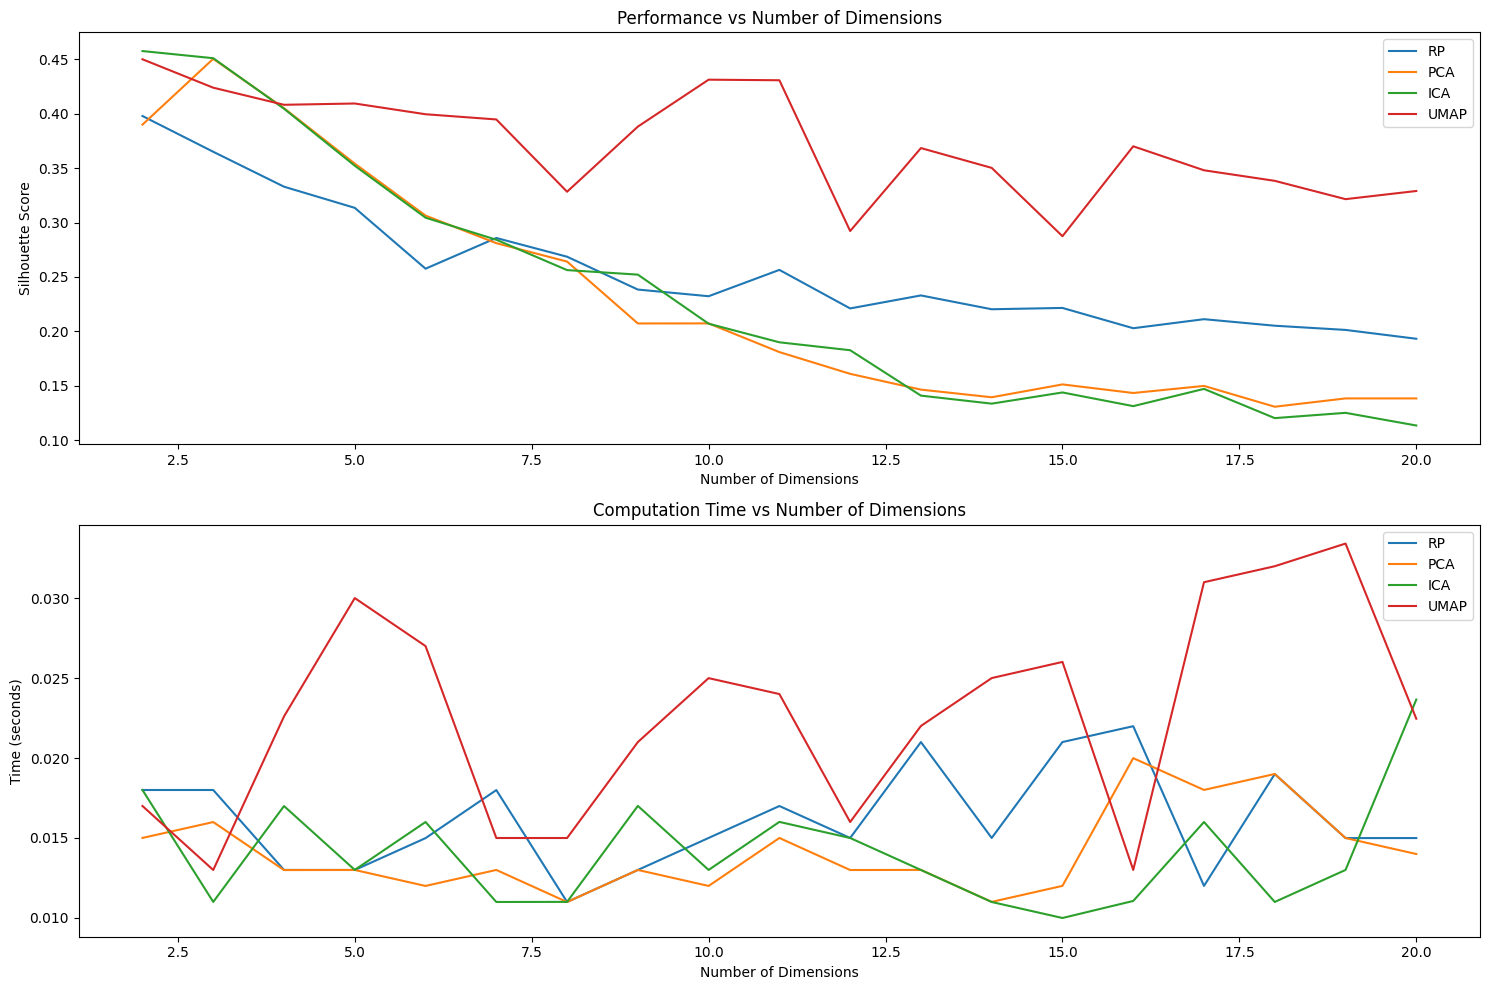

In [16]:
# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for algo, data in results.items():
    plt.plot(range(2, len(data['scores']) + 2), data['scores'], label=algo)
plt.xlabel('Number of Dimensions')
plt.ylabel('Silhouette Score')
plt.legend()
plt.title('Performance vs Number of Dimensions')

plt.subplot(2, 1, 2)
for algo, data in results.items():
    plt.plot(range(2, len(data['times']) + 2), data['times'], label=algo)
plt.xlabel('Number of Dimensions')
plt.ylabel('Time (seconds)')
plt.legend()
plt.title('Computation Time vs Number of Dimensions')

plt.tight_layout()
plt.show()

In [17]:
# Save the best performing datasets
for algo, data in results.items():
    best_dims = data['best_dims']
    best_score = data['best_score']
    best_data = data['best_data']
    
    print(f"{algo}: Best dimensions = {best_dims}, Best score = {best_score}")
    
    # Save as CSV
    df = pd.DataFrame(best_data, columns=[f"Dim_{i+1}" for i in range(best_dims)])
    df.to_csv(f"3026_{algo}_best_{best_dims}d.csv", index=False)
    print(f"Saved {algo} data with {best_dims} dimensions to {algo}_best_{best_dims}d.csv")

print("All best-performing datasets have been saved.")

RP: Best dimensions = 2, Best score = 0.3979522827303751
Saved RP data with 2 dimensions to RP_best_2d.csv
PCA: Best dimensions = 3, Best score = 0.4505276024765498
Saved PCA data with 3 dimensions to PCA_best_3d.csv
ICA: Best dimensions = 2, Best score = 0.45766233582023225
Saved ICA data with 2 dimensions to ICA_best_2d.csv
UMAP: Best dimensions = 2, Best score = 0.4500986337661743
Saved UMAP data with 2 dimensions to UMAP_best_2d.csv
All best-performing datasets have been saved.


In [18]:
# Extract the best dimensions based on the highest silhouette score for each algorithm
best_dimensions = {
    'PCA': results['PCA']['best_dims'],
    'ICA': results['ICA']['best_dims'],
    'RP': results['RP']['best_dims'],
    'UMAP': results['UMAP']['best_dims']
}

print(f"Best dimensions based on silhouette score - PCA: {best_dimensions['PCA']}, ICA: {best_dimensions['ICA']}, RP: {best_dimensions['RP']}, UMAP: {best_dimensions['UMAP']}")

Best dimensions based on silhouette score - PCA: 3, ICA: 2, RP: 2, UMAP: 2


In [19]:
# Function to add best dimensions to the original dataset and save CSV
def add_best_dimensions_and_save(original_df, X_reduced, algorithm_name, optimal_dims):
    df_with_best_dimensions = original_df.copy()
    
    # Add only the best dimensions
    for i in range(optimal_dims):
        df_with_best_dimensions[f'{algorithm_name}_best_dim_{i+1}'] = X_reduced[:, i]
    
    # Save the new dataset with added best dimensions
    filename = f'dataset3026_with_{algorithm_name}_best_dimensions.csv'
    df_with_best_dimensions.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"Dataset with {algorithm_name} best dimensions has been saved as '{filename}'")
    
    return df_with_best_dimensions

In [20]:
# Apply dimensionality reduction and save results
df_pca = add_best_dimensions_and_save(original_df, X_pca, 'PCA', pca_optimal_dims)
df_ica = add_best_dimensions_and_save(original_df, X_ica, 'ICA', ica_optimal_dims)
df_rp = add_best_dimensions_and_save(original_df, X_rp, 'RP', rp_optimal_dims)
df_umap = add_best_dimensions_and_save(original_df, X_umap, 'UMAP', umap_optimal_dims)

# Display the first few rows and basic info of one of the new datasets (e.g., PCA)
print("\nFirst few rows of the dataset with PCA best dimensions:")
print(df_pca.head())
print("\nBasic info of the dataset with PCA best dimensions:")
print(df_pca.info())

Dataset with PCA best dimensions has been saved as 'dataset3026_with_PCA_best_dimensions.csv'
Dataset with ICA best dimensions has been saved as 'dataset3026_with_ICA_best_dimensions.csv'
Dataset with RP best dimensions has been saved as 'dataset3026_with_RP_best_dimensions.csv'
Dataset with UMAP best dimensions has been saved as 'dataset3026_with_UMAP_best_dimensions.csv'

First few rows of the dataset with PCA best dimensions:
   number  TeacherID speaker  \
0       1       3026       T   
1       2       3026       T   
2       3       3026       S   
3       4       3026       T   
4       5       3026       S   

                                           utterance  ut  rc  PCA_best_dim_1  \
0  Ok. So you’re going to be talking about - we’r...   Q  SK        0.160469   
1  You all should probably be able to tell me tha...   P  EX        2.202308   
2                                         Nope. No.   Ry  EX       -0.761358   
3     You don’t? Don’t you all ride the school bus?   

In [21]:
# Create a single dataset with best dimensions from all algorithms
df_all_best = original_df.copy()
for algo, X_reduced, optimal_dims in [('PCA', X_pca, pca_optimal_dims), 
                                      ('ICA', X_ica, ica_optimal_dims), 
                                      ('RP', X_rp, rp_optimal_dims), 
                                      ('UMAP', X_umap, umap_optimal_dims)]:
    for i in range(optimal_dims):
        df_all_best[f'{algo}_best_dim_{i+1}'] = X_reduced[:, i]

df_all_best.to_csv('dataset3026_with_all_best_dimensions.csv', index=False, encoding='utf-8-sig')
print("\nDataset with all best dimensions has been saved as 'dataset_with_all_best_dimensions.csv'")

# Print the number of best dimensions for each algorithm
print(f"\nNumber of best dimensions:")
print(f"PCA: {pca_optimal_dims}")
print(f"ICA: {ica_optimal_dims}")
print(f"RP: {rp_optimal_dims}")
print(f"UMAP: {umap_optimal_dims}")


Dataset with all best dimensions has been saved as 'dataset_with_all_best_dimensions.csv'

Number of best dimensions:
PCA: 17
ICA: 19
RP: 2
UMAP: 2


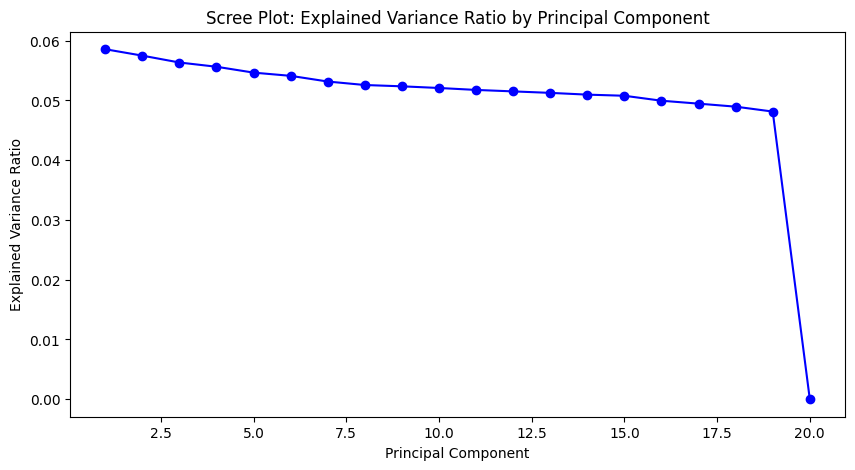

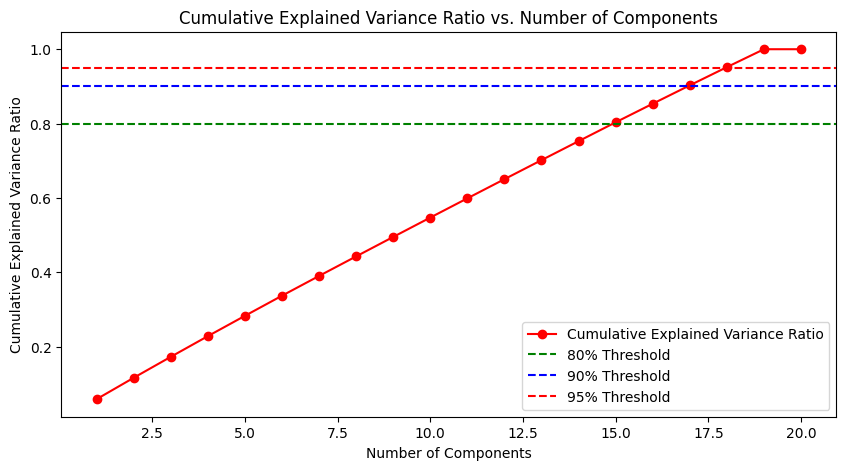

Number of components needed for 80.0% accuracy: 15
Number of components needed for 90.0% accuracy: 17
Number of components needed for 95.0% accuracy: 18


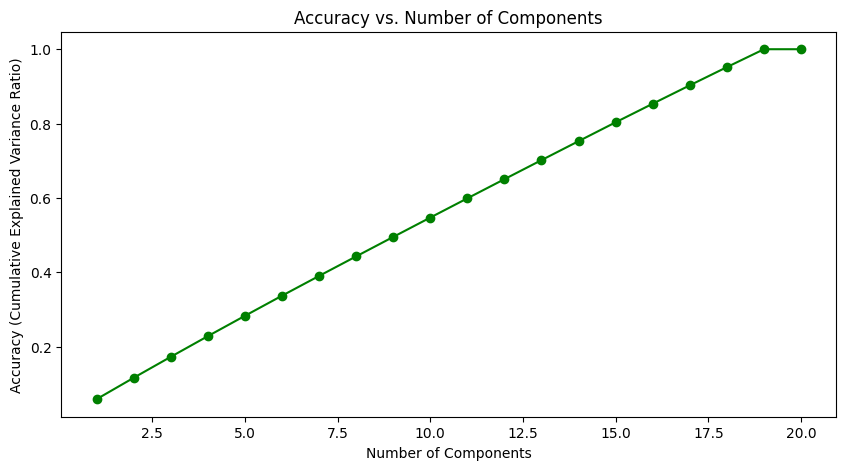

In [22]:
# PCA: Accuracy graphs with eigenvalues
pca = PCA()
pca.fit(X_scaled)

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot: Explained Variance Ratio by Principal Component')
plt.show()

# Cumulative explained variance ratio plot
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.axhline(y=0.8, color='g', linestyle='--')
plt.axhline(y=0.9, color='b', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.legend(['Cumulative Explained Variance Ratio', '80% Threshold', '90% Threshold', '95% Threshold'])
plt.show()

# Print the number of components needed for different accuracy levels
accuracy_levels = [0.8, 0.9, 0.95]
for level in accuracy_levels:
    n_components = next(i for i, v in enumerate(cumulative_variance_ratio) if v >= level) + 1
    print(f"Number of components needed for {level*100}% accuracy: {n_components}")

# Accuracy vs. Number of Components
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'go-')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy (Cumulative Explained Variance Ratio)')
plt.title('Accuracy vs. Number of Components')
plt.show()

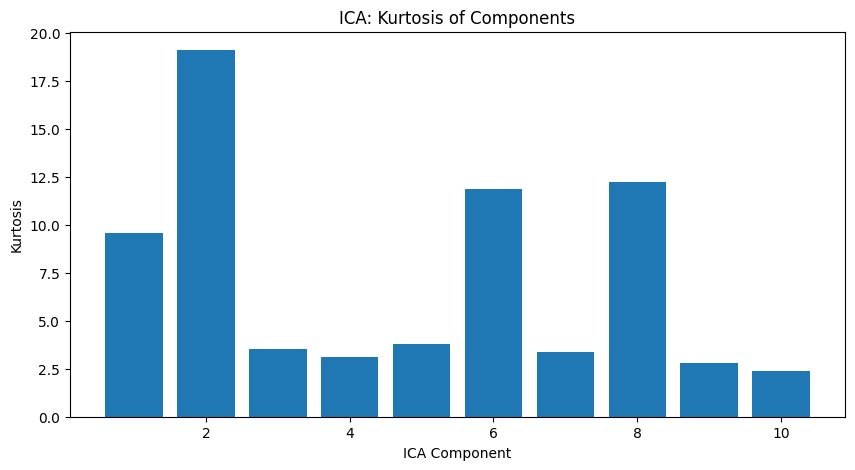

Kurtosis values of ICA components:
[ 9.59518924 19.10817623  3.5337908   3.09312881  3.78452493 11.85789081
  3.38012482 12.25235977  2.81076201  2.38942587]


In [23]:
# 2. ICA: Kurtosis of components
ica = FastICA(n_components=10, random_state=42)
X_ica = ica.fit_transform(X_scaled)

kurtosis_values = kurtosis(X_ica, axis=0)
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), kurtosis_values)
plt.xlabel('ICA Component')
plt.ylabel('Kurtosis')
plt.title('ICA: Kurtosis of Components')
plt.show()

print("Kurtosis values of ICA components:")
print(kurtosis_values)

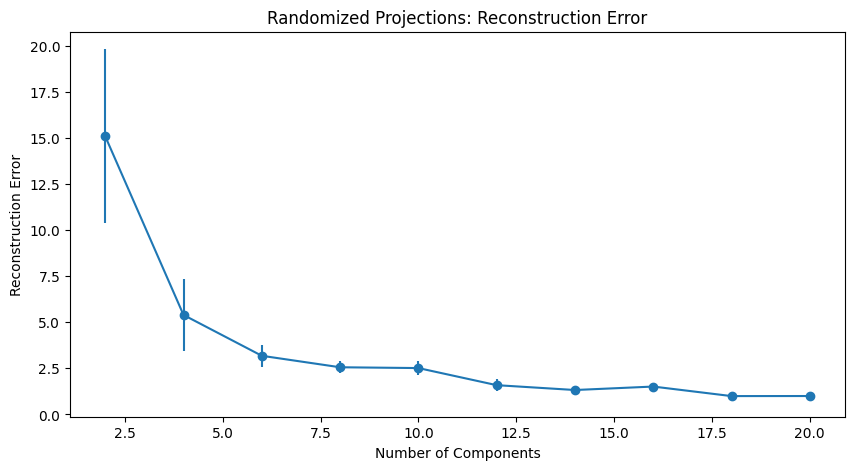

In [24]:
# 3. Randomized Projections: Reconstruction error and variation
def rp_reconstruction_error(X, n_components, n_runs=5):
    errors = []
    for _ in range(n_runs):
        rp = GaussianRandomProjection(n_components=n_components, random_state=None)
        X_rp = rp.fit_transform(X)
        X_reconstructed = np.dot(X_rp, rp.components_)
        error = mean_squared_error(X, X_reconstructed)
        errors.append(error)
    return np.mean(errors), np.std(errors)

n_components_range = range(2, 21, 2)
mean_errors = []
std_errors = []

for n_components in n_components_range:
    mean_error, std_error = rp_reconstruction_error(X_scaled, n_components)
    mean_errors.append(mean_error)
    std_errors.append(std_error)

plt.figure(figsize=(10, 5))
plt.errorbar(n_components_range, mean_errors, yerr=std_errors, fmt='o-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Randomized Projections: Reconstruction Error')
plt.show()

In [25]:
# 4. Rank and Colinearity
rank = np.linalg.matrix_rank(X_scaled)
print(f"Rank of the data: {rank}")

Rank of the data: 19


In [26]:
# Compute correlation matrix
corr_matrix = np.corrcoef(X_scaled.T)

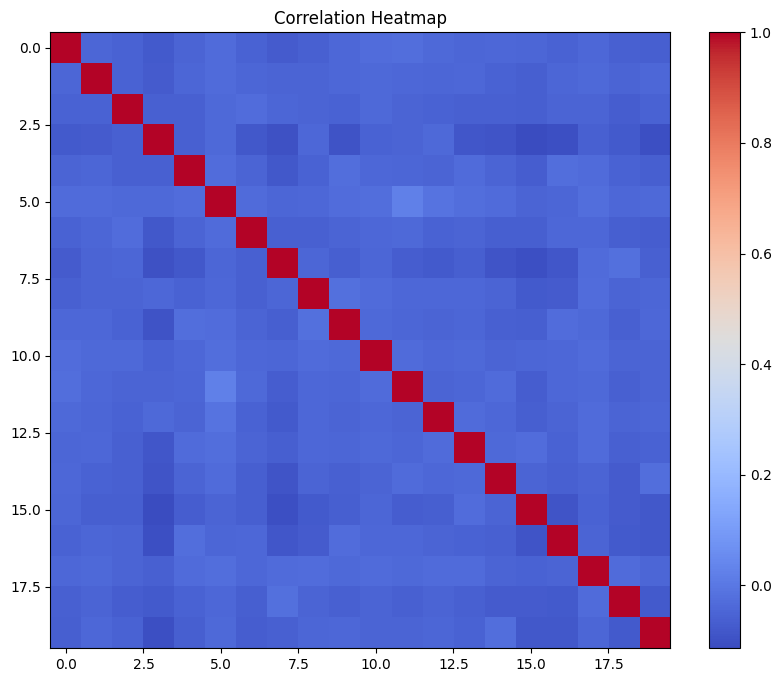

In [27]:
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.show()

In [28]:
# Compute and print condition number
cond_num = np.linalg.cond(X_scaled)
print(f"Condition number: {cond_num}")

Condition number: 344755217938242.1


C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\soon1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


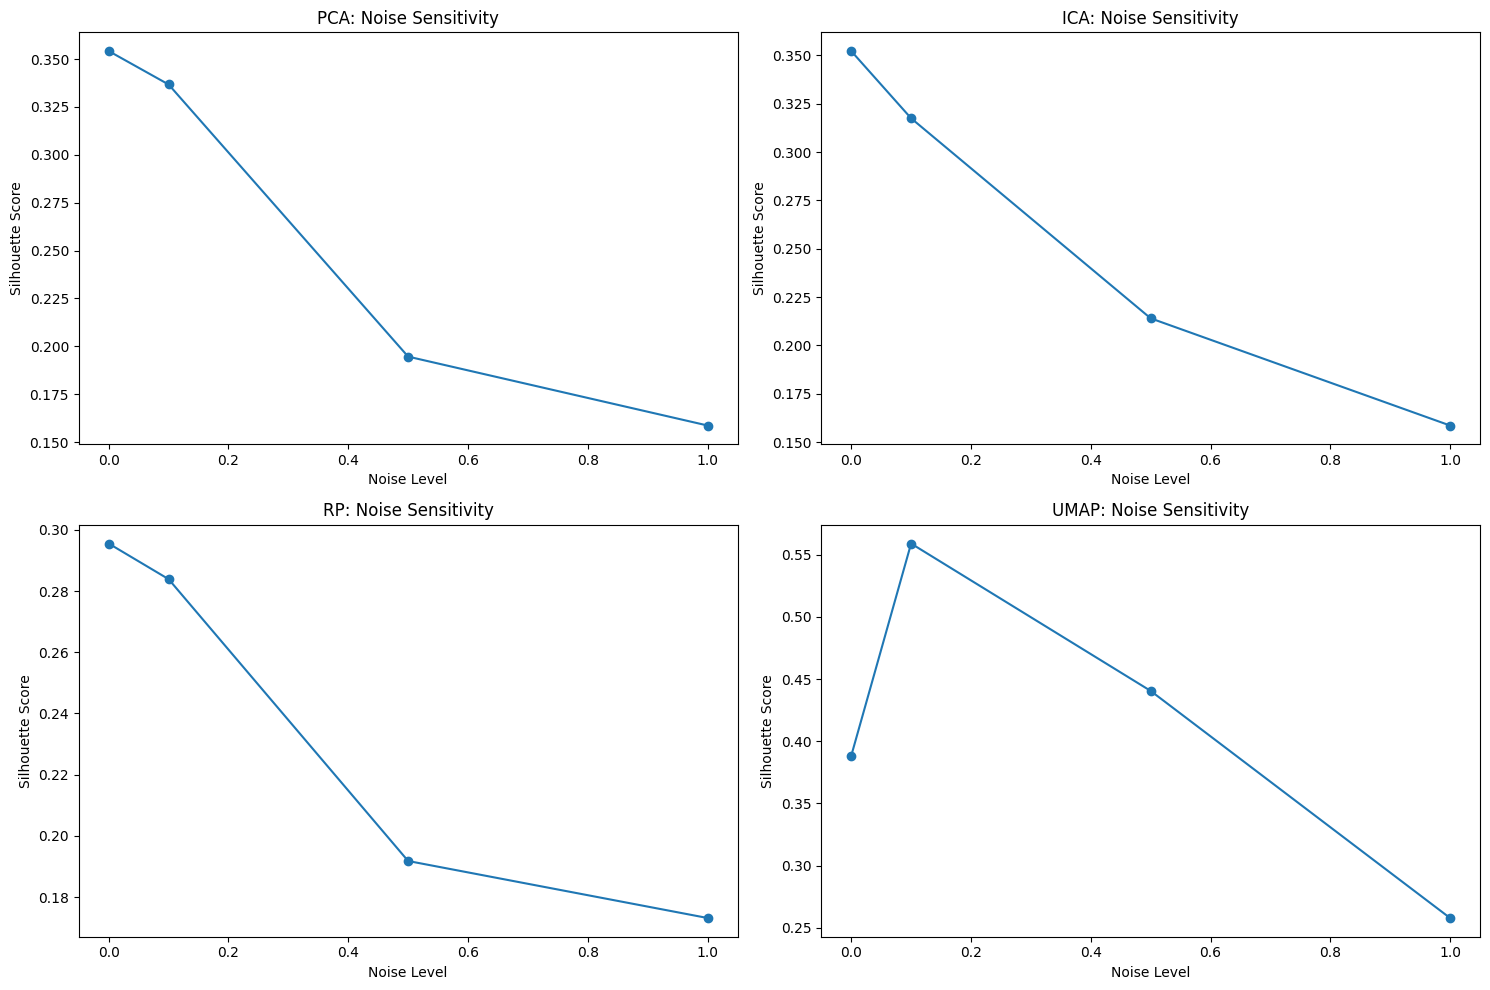

In [29]:
# 5. Noise sensitivity
def add_noise(X, noise_level):
    return X + np.random.normal(0, noise_level, X.shape)

noise_levels = [0, 0.1, 0.5, 1.0]
algorithms = [PCA(n_components=5), FastICA(n_components=5), GaussianRandomProjection(n_components=5), umap.UMAP(n_components=5)]
algo_names = ['PCA', 'ICA', 'RP', 'UMAP']

plt.figure(figsize=(15, 10))

for i, algo in enumerate(algorithms):
    sil_scores = []
    for noise in noise_levels:
        X_noisy = add_noise(X_scaled, noise)
        X_reduced = algo.fit_transform(X_noisy)
        kmeans = KMeans(n_clusters=5, random_state=42)
        clusters = kmeans.fit_predict(X_reduced)
        sil_score = silhouette_score(X_reduced, clusters)
        sil_scores.append(sil_score)
    
    plt.subplot(2, 2, i+1)
    plt.plot(noise_levels, sil_scores, 'o-')
    plt.xlabel('Noise Level')
    plt.ylabel('Silhouette Score')
    plt.title(f'{algo_names[i]}: Noise Sensitivity')

plt.tight_layout()
plt.show()